<a href="https://colab.research.google.com/github/ayaka1802/corab-1.github.io/blob/main/prediction_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**推論→gradcamでどこを見てたか可視化**

In [ ]:
%tensorflow_version 1.x 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import shutil
import math
import random as rn
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import cv2
from google.colab.patches import cv2_imshow

print(tf.__version__)

# 学習済モデルを保存した h5 ファイルを読み込むライブラリ
# バージョン指定インストール
# h5 ファイルの読み込みにバージョン合わせが必要になったらしい
#https://qiita.com/Hiroki-Fujimoto/items/b078bfb680fb710c38c1
!sudo pip3 install h5py==2.10.0
import h5py
print("h5py version: " + h5py.__version__)



from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend as K 

# 念のためTensorFlowのバージョンを確認
print("TensorFlow version: " + tf.__version__)

TensorFlow 1.x selected.
1.15.2
h5py version: 2.10.0
TensorFlow version: 1.15.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


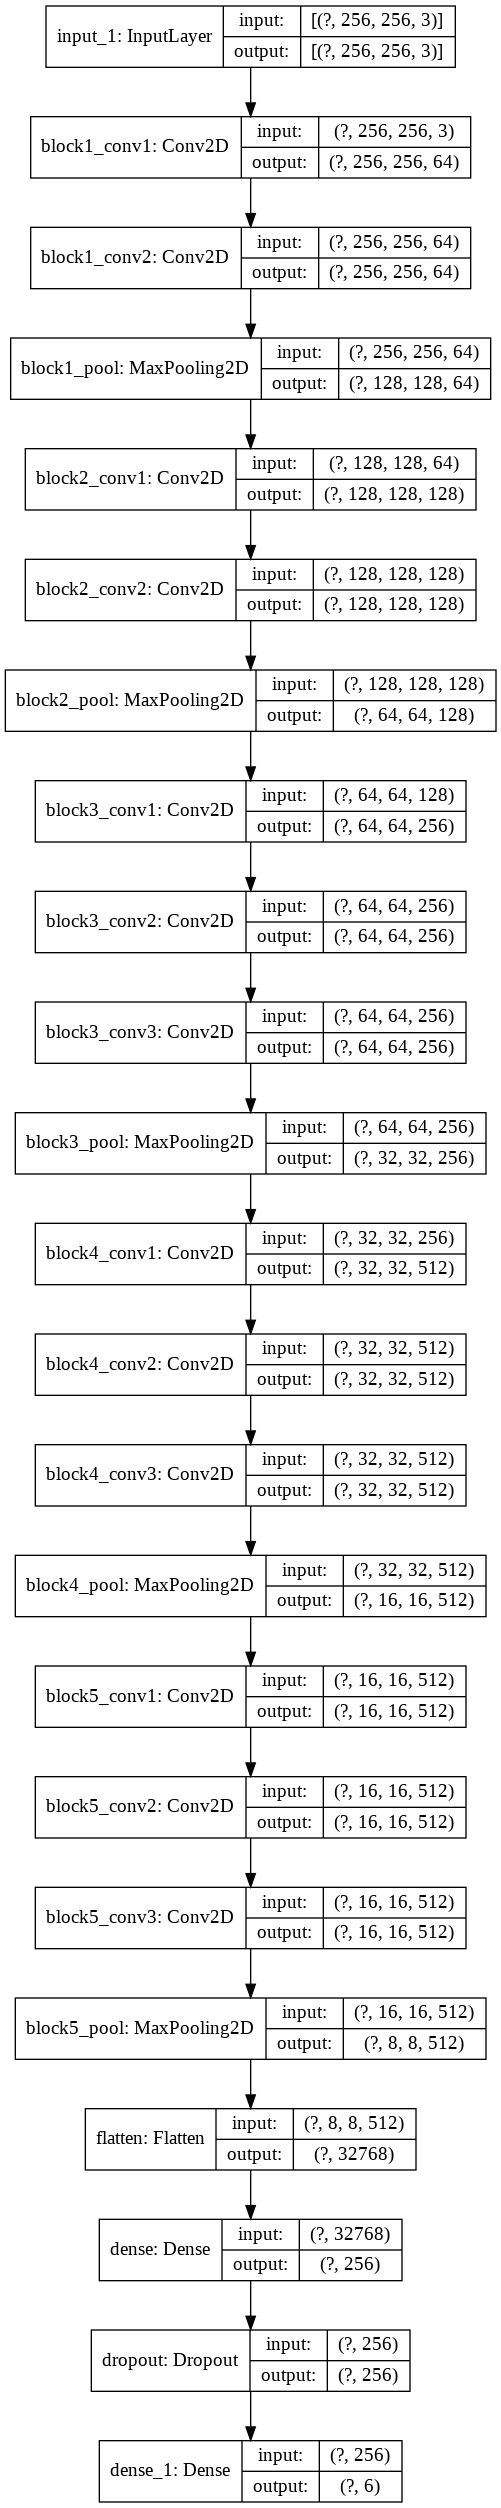

In [ ]:
# 学習済みモデルのパスを指定
path = "/content/drive/My Drive/Colab/Trial/model/my_model.h5"

# モデルを読み込み
model = load_model(path)

# 読み込んだモデルを可視化して確認
plot_model(model, show_shapes=True)

In [ ]:
# モデルを可視化して確認2
model.summary()

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0

Text(0.5, 1.0, 'Plumeria.jpeg\n(580, 800, 3)')

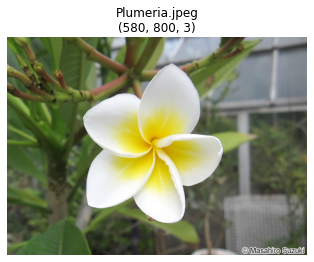

In [ ]:
# 画像ファイルのパスを指定
path = "/content/drive/MyDrive/Colab/Trial/datasets/Plumeria.jpeg"

filename = os.path.basename(path)

# 画像の読み込みと表示
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
title = "{}\n{}".format(filename, img.shape)
plt.title(title)

newsize= (256, 256)


(-0.5, 255.5, 255.5, -0.5)

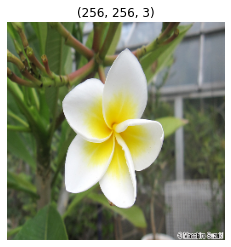

In [ ]:
# モデルに合うようにnewsizeを設定
# 読み込んだモデルから適切なサイズを自動的に設定できる
newsize = model.layers[0].input_shape[0][1:3] 

print("newsize=", newsize)

# 画像サイズを変更
img_modified = cv2.resize(img, newsize)

# ピクセル値の最大値が1.0になるように規格化
img_modified = img_modified/255.0

# 表示して確認
plt.imshow(img_modified)
plt.title(img_modified.shape)
plt.axis("off")

In [ ]:
#入力データ生成（モデルの入力サイズに合うように入力データの次元を変更）
input_data = np.expand_dims(img_modified, 0)
input_data.shape

(1, 256, 256, 3)

In [ ]:
#推論
pred = model.predict(input_data)
score = pred[0]

print("2={:.2f}, 3={:.2f},Erysimumcheiri={:.2f}, 4={:.2f},5={:.2f}, 1={:.2f}".format(score[0], score[1],score[2], score[3],score[4], score[5]))

2=0.00, 3=0.00,Erysimumcheiri=0.00, 4=0.00,5=0.00, 1=1.00


In [ ]:
# モデルを可視化して確認
model.summary()

Model: "test_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0

In [ ]:
# 最後のconvalutional layerを指定
LAYER_NAME = 'block5_conv3' 

last_conv_layer = model.get_layer(LAYER_NAME)

(16, 16, 512)
(512,)


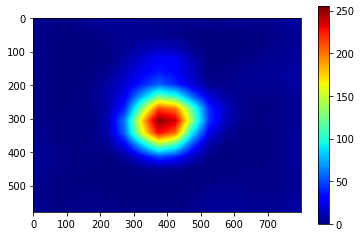

In [ ]:
N = np.argmax(pred)
model_output = model.output[:,N]

grads = K.gradients(model_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis =(0,1,2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_val, conv_output_val = iterate([input_data])

print(conv_output_val.shape)
print(pooled_grads_val.shape)

for i in range(pooled_grads_val.shape[0]):
    conv_output_val[:, :, i] *= pooled_grads_val[i]


# ヒートマップの生成
heatmap = np.mean(conv_output_val, axis = -1)

# ヒートマップの後処理
heatmap = np.maximum(heatmap, 0)
heatmap = heatmap/heatmap.max()

# 元の画像と同じサイズになるようにヒートマップのサイズを変更
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# ヒートマップをRGBに変換
heatmap = np.uint8(255 * heatmap)
# JETのカラーマップを適用
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# RGBに変換
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

plt.imshow(heatmap, 'jet')
plt.colorbar()



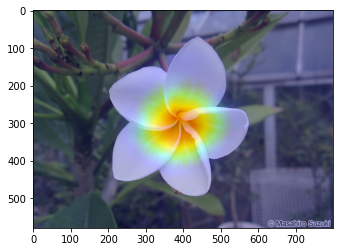

In [ ]:
# ヒートマップと元の画像を重ねる
# 0.4はヒートマップの強度係数
superimposed_img = heatmap*0.4 + img
superimposed_img = superimposed_img/np.max(superimposed_img)

# 画像を表示
plt.imshow(superimposed_img)